## Data Summary  
#### Import Python Lirbaries

In [ ]:
# Configure TF logging and GPU memory behaviour
import os
import logging
import warnings

# Set TF C++ logging level BEFORE importing tensorflow to suppress low-level messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # 0=DEBUG,1=INFO,2=WARNING,3=ERROR
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# Reduce Python-level TF logging
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Optionally suppress specific noisy UserWarnings from Keras/TF
# warnings.filterwarnings('ignore', message=r'Your input ran out of data; interrupting training.*', category=UserWarning)
# warnings.filterwarnings('ignore', message=r'.*Local rendezvous.*', category=UserWarning)

# Keep memory growth setting
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [1]:
import kagglehub
# Log into Kaggle to access dataset
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# Import data to colab cache
print('Downloading data from Kaggle...')
histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')
print('Data source import complete.')

# Move from cache to colab content folder
print('Moving data to ./content/ directory...')
!cp -r /root/.cache/kagglehub/competitions/histopathologic-cancer-detection/* /content/
print('Data moved successfully.')

100%|██████████| 6.31G/6.31G [04:50<00:00, 23.3MB/s]

Extracting files...


Data source import complete.
Moving data to ./content/ directory...
Data moved successfully.


In [3]:
# Move from cache to colab content folder
print('Moving data to ./content/ directory...')
!cp -r /root/.cache/kagglehub/competitions/histopathologic-cancer-detection/* /content/
print('Data moved successfully.')

Moving data to ./content/ directory...
Data moved successfully.


In [8]:
# Import core libraries and ML utilities
import os
import random
import glob
import math
import tifffile as tiff
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# from tensorflow.keras import layers, models

# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

#### Import Datasets

In [9]:
# Paths to data folders and labels file
# train_images_path = './train/'
# test_images_path  = './test/'
# train_labels_csv  = './train_labels.csv'

train_images_path = '/content/train/'
test_images_path  = '/content/test/'
train_labels_csv  = '/content/train_labels.csv'

# Load training labels
labels_df = pd.read_csv(train_labels_csv)

# Create a list of the file paths to the images in the train and test folders
train_file_paths = glob.glob(os.path.join(train_images_path, '*.tif'))
test_file_paths = glob.glob(os.path.join(test_images_path, '*.tif'))

print(f'Count of train images = {len(train_file_paths):,}\nCount of test images = {len(test_file_paths):,}')

Count of train images = 220,025
Count of test images = 57,458


In [19]:
# Image config
IMG_SIZE = 96                   # target size to resize patches to
CHANNELS = 3                    # RGB images

# Tensorflow pipeline config
GPU_dict = {'RTX 3050 Ti':50, 'GC T4 GPU':80, 'GC TPU':64}
SHARD_SIZE = round(len(train_file_paths) / GPU_dict['GC TPU'])   # number of tf.train.Examples per TFRecord shard ()
BATCH_SIZE = 64                 # training batch size
AUTOTUNE = tf.data.AUTOTUNE   # let tf.data choose parallelism

###

#### Check Image Sizes
- Ensure all of the images are 96 x 96 pixels with 3 channels (red, green, blue)

In [13]:
skip = True
def check_image_sizes(folder):
    bad_files = []
    if skip == False:
        for f in os.listdir(folder):
            path = os.path.join(folder, f)
            with tiff.TiffFile(path) as img:
                h, w, c = img.pages[0].shape
            if h != IMG_SIZE or w != IMG_SIZE or c != CHANNELS:
                bad_files.append(f)
    if len(bad_files)<=0 or skip==True:
        print(f'All {len(os.listdir(folder)):,} .tif files in the {folder} folder are {IMG_SIZE} x {IMG_SIZE} pixels with {CHANNELS} channels.')
    else:
        print(f"Found {len(bad_files)} files not matching image sizes of {IMG_SIZE} x {IMG_SIZE} x {CHANNELS}:")
        print(bad_files)

check_image_sizes(train_images_path)
check_image_sizes(test_images_path)

All 220,025 .tif files in the /content/train/ folder are 96 x 96 pixels with 3 channels.
All 57,458 .tif files in the /content/test/ folder are 96 x 96 pixels with 3 channels.


## Exploratory Data Analysis (EDA)

In this section we inspect the data visually and numerically.  We load a handful of sample images from each class to examine typical patterns and variations.  Because the images are stored as TIFF files, we use the Pillow library to read them.  We also compute basic statistics such as the mean and standard deviation of pixel intensities per channel to inform normalisation strategies.

The class distribution plot above shows that the dataset is slightly imbalanced (≈59 % negative vs 41 % positive).  To mitigate bias during training, you may explore class weighting or resampling strategies.

#### Sample of Training Data Images
- something here ...

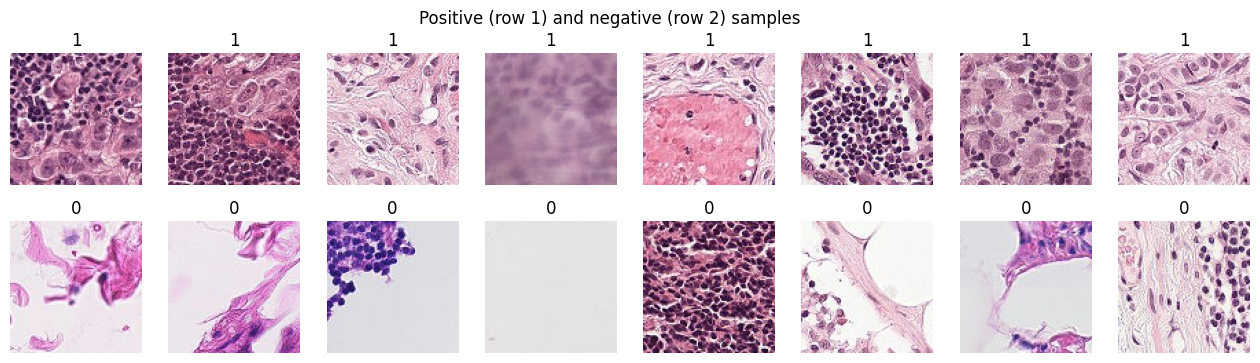

In [8]:
# Visualize random samples from each class
def load_image(img_id, directory):
    file_path = os.path.join(directory, f'{img_id}.tif')
    return Image.open(file_path)

positive_ids = labels_df[labels_df['label'] == 1]['id'].sample(8).tolist()
negative_ids = labels_df[labels_df['label'] == 0]['id'].sample(8).tolist()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, img_id in enumerate(positive_ids):
    img = load_image(img_id, train_images_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('1')

for i, img_id in enumerate(negative_ids):
    img = load_image(img_id, train_images_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('0')

plt.suptitle('Positive (row 1) and negative (row 2) samples')
plt.show()

#### Visualize RGB Channels
- Plot the red, green, blue channels from a random training .tif file

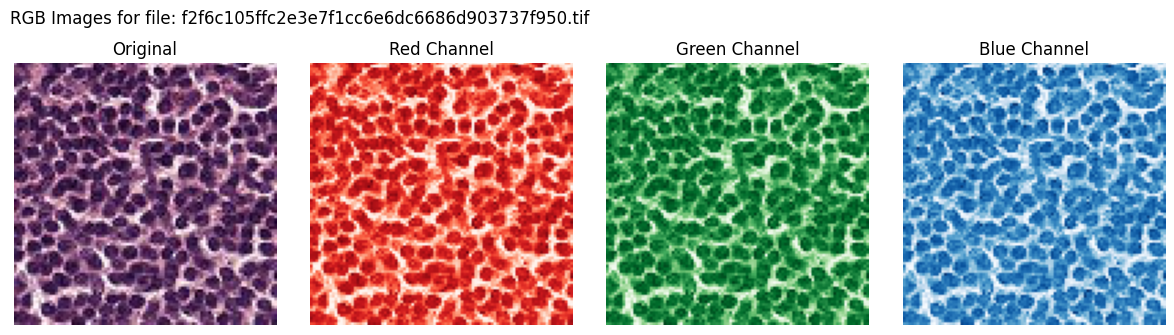

In [9]:
# Randomly select a training image
rand_idx = random.randint(0, len(os.listdir(train_images_path))+1)
filename = os.listdir(train_images_path)[rand_idx]

# Path to one example image
img_path = os.path.join(train_images_path, filename)

# Read the image (as NumPy array)
img = tiff.imread(img_path)

# Display each channel with its color
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ['Original', 'Red Channel', 'Green Channel', 'Blue Channel']
cmaps  = [None, 'Reds_r', 'Greens_r', 'Blues_r']

# Plot original RGB + individual color channels
axes[0].imshow(img)
axes[0].set_title(titles[0])
axes[0].axis('off')
for i, (title, cmap) in enumerate(zip(titles[1:], cmaps[1:])):
    axes[i+1].imshow(img[:, :, i], cmap=cmap)
    axes[i+1].set_title(title)
    axes[i+1].axis('off')
plt.tight_layout()
plt.suptitle(f'RGB Images for file: {filename}', y=1.1, horizontalalignment='right')
plt.show()

> Something about these RGB images...

#### RGB Histograms by Label
- Plot of distributions by label type

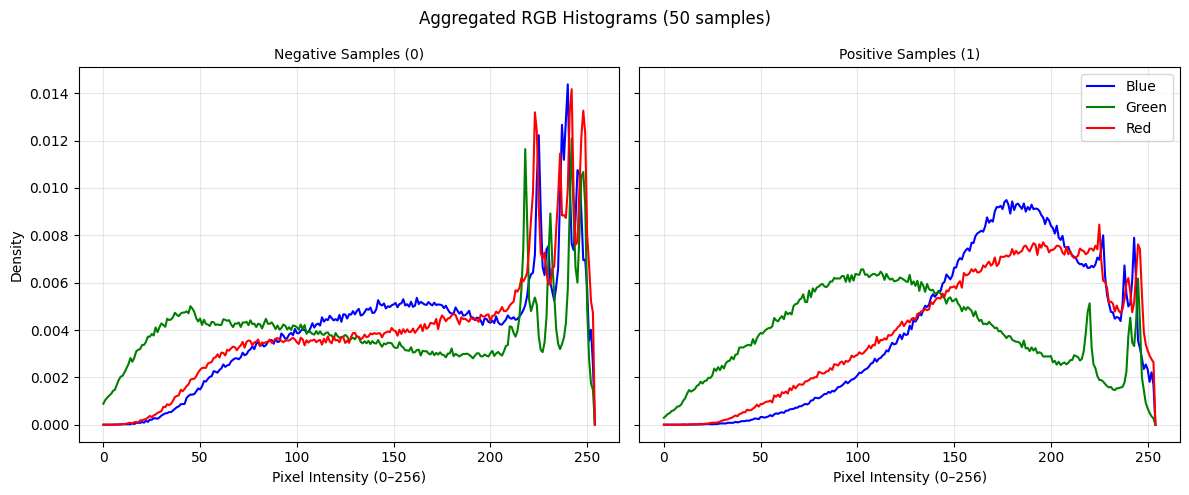

In [10]:
# Choose a random set of files from the positive (1) and negative (0) labels
n = 50
positive_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==1]['id'].sample(n).to_list()]
negative_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==0]['id'].sample(n).to_list()]

# Function to create RGB histogram data
def get_histogram_data(files):
    hists = np.zeros((3, 255), dtype=np.float64)
    for path in files:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        for ch in range(3):
            hists[ch] += cv2.calcHist([img], [ch], None, [255], [1, 255]).ravel()
    return hists

# Get histogram data
negative_files_hist_data = get_histogram_data(negative_files)
positive_files_hist_data = get_histogram_data(positive_files)

negative_files_probability_data = negative_files_hist_data / negative_files_hist_data.sum(axis=1, keepdims=True)
positive_files_probability_data = positive_files_hist_data / positive_files_hist_data.sum(axis=1, keepdims=True)

# Plot RGB Histograms
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

ax0.plot(negative_files_probability_data[0], 'b', label='Blue')
ax0.plot(negative_files_probability_data[1], 'g', label='Green')
ax0.plot(negative_files_probability_data[2], 'r', label='Red')
ax0.set_title('Negative Samples (0)', fontdict={'fontsize':10})
ax0.set_xlabel('Pixel Intensity (0–256)')
ax0.set_ylabel('Density')
ax0.grid(True, alpha=0.3)

ax1.plot(positive_files_probability_data[0], 'b', label='Blue')
ax1.plot(positive_files_probability_data[1], 'g', label='Green')
ax1.plot(positive_files_probability_data[2], 'r', label='Red')
ax1.set_title('Positive Samples (1)', fontdict={'fontsize':10})
ax1.set_xlabel('Pixel Intensity (0–256)')
ax1.grid(True, alpha=0.3)
ax1.legend()

plt.suptitle(f'Aggregated RGB Histograms (n={n:,} samples)')
plt.tight_layout()
plt.show()

> Visual differences between positive and negative samples...

#### Distribution of Labels
- Understand balance of dataset

Class counts:
label
0    130908
1     89117
Name: count, dtype: int64


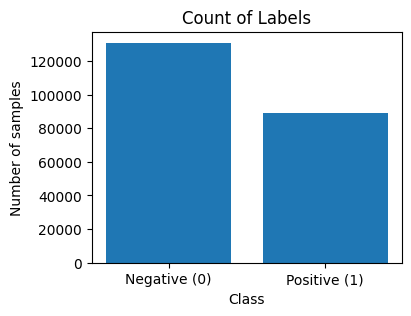

In [11]:
# Inspect label distribution
class_counts = labels_df['label'].value_counts().sort_index()
print('Class counts:')
print(class_counts)

# Plot label distribution
plt.figure(figsize=(4,3))
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values)
plt.title('Count of Labels')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

> Dataset is imbalanced....

#### Analysis Plan

Based on the EDA, the following observations guide our analysis:

- The label distribution shows a moderate class imbalance; using class weights or oversampling may help the model focus on minority (positive) samples.
- The images have strong staining variability and sometimes contain artefacts; data augmentation (random flips, rotations, brightness/contrast adjustments) can improve generalisation.

**Analysis plan:**

1. Split the labelled data into training and validation sets (e.g. 80/20).
2. Preprocess images: resize to a common size (96×96), apply augmentations on the fly, and normalise by global channel statistics.
3. Train several CNN architectures ranging from a simple custom CNN to transfer learning models (e.g. ResNet50, DenseNet169).
4. Tune hyperparameters such as learning rate, optimiser, dropout rate, batch size and number of layers using a search strategy (random search or Bayesian optimisation).
5. Evaluate the models on the validation set using metrics appropriate for class imbalance (AUC, precision, recall, F1).

## CNN Modeling

#### Train - Validation Split
- The Kaggle dataset only provides labels for the training images, so we will need to subdivide the training images into a training and validation set (80% training, 20% validation) in order to be able to test the performace of the CNN models.

#### Create Datasets

In [16]:
def create_train_val_datasets():
    # Split labels_df into training and validation sets
    print(f'Splitting labels into training and validation sets...\n')
    training_ids, validation_ids, training_labels, validation_labels = train_test_split(
        labels_df['id'].values,
        labels_df['label'].values,
        test_size=0.2,
        random_state=666
    )

    # Create train_ds and val_ds datasets
    if not os.path.exists(f'train_ds.npy') and os.path.exists(f'val_ds.npy'):
        # Create lists of training and validation filenames
        training_filenames = [f'./train/{i}.tif' for i in training_ids]
        validation_filenames = [f'./train/{i}.tif' for i in validation_ids]

        h = IMG_SIZE
        w = IMG_SIZE
        c = CHANNELS

        for filenames, dataset_name in zip([training_filenames, validation_filenames], ['train_ds', 'val_ds']):
            print(f'Creating dataset: {dataset_name}')
            n = len(filenames)
            df = np.empty((n, h, w, c), dtype='uint8')
            for i, filename in enumerate(filenames):
                with Image.open(filename) as im:
                    df[i] = np.array(im)

            # Save dataset
            print(f'Saving {dataset_name}.npy to directory\n')
            np.save(f'{dataset_name}.npy', df)
    # If the train_ds and val_ds have already been created then download from directory
    else:
        print(f'The file train_ds.npy already exists, loading train_ds from directory...\n')
        train_ds = np.load(f'train_ds.npy')
        print(f'The file val_ds.npy already exists, loading val_ds from directory...\n')
        val_ds = np.load(f'val_ds.npy')

    return train_ds, val_ds, training_labels, validation_labels

train_ds, val_ds, training_labels, validation_labels = create_train_val_datasets()

Splitting labels into training and validation sets...

The file train_ds.npy already exists, loading train_ds from directory...

The file val_ds.npy already exists, loading val_ds from directory...



In [17]:
import os
import math
import tensorflow as tf
import numpy as np

# Helper functions to create TF features
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):  # if EagerTensor
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Function to serialize a tf.train.Example
def serialize_example(image_array, label, height=IMG_SIZE, width=IMG_SIZE, channels=CHANNELS):
    # image_array is a uint8 numpy array of shape (h, w, c)
    image_bytes = image_array.tobytes()  # raw bytes
    feature = {
        'image': _bytes_feature(image_bytes),
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'channels': _int64_feature(channels),
        'label': _int64_feature(int(label)),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Function to write a list/array into multiple shards
def write_tfrecord_shards(images, labels, out_dir, prefix, shard_size=SHARD_SIZE):
    os.makedirs(out_dir, exist_ok=True)
    n = len(images)
    num_shards = math.ceil(n / shard_size)
    print(f'Writing {n} records to {num_shards} shards in {out_dir} ...')

    for shard_id in range(num_shards):
        start = shard_id * shard_size
        end = min((shard_id + 1) * shard_size, n)
        shard_path = os.path.join(out_dir, f'{prefix}_{shard_id:03d}.tfrec')
        with tf.io.TFRecordWriter(shard_path) as writer:
            for i in range(start, end):
                example = serialize_example(images[i], labels[i])
                writer.write(example)
        print(f'  wrote {shard_path}  [{start}:{end}]')

In [18]:
write_tfrecord_shards(train_ds, training_labels, out_dir='./tfrecords/train', prefix='train')
write_tfrecord_shards(val_ds,   validation_labels, out_dir='./tfrecords/val',   prefix='val')

del train_ds, val_ds

Writing 176020 records to 52 shards in ./tfrecords/train ...
  wrote ./tfrecords/train/train_000.tfrec  [0:3438]
  wrote ./tfrecords/train/train_001.tfrec  [3438:6876]
  wrote ./tfrecords/train/train_002.tfrec  [6876:10314]
  wrote ./tfrecords/train/train_003.tfrec  [10314:13752]
  wrote ./tfrecords/train/train_004.tfrec  [13752:17190]
  wrote ./tfrecords/train/train_005.tfrec  [17190:20628]
  wrote ./tfrecords/train/train_006.tfrec  [20628:24066]
  wrote ./tfrecords/train/train_007.tfrec  [24066:27504]
  wrote ./tfrecords/train/train_008.tfrec  [27504:30942]
  wrote ./tfrecords/train/train_009.tfrec  [30942:34380]
  wrote ./tfrecords/train/train_010.tfrec  [34380:37818]
  wrote ./tfrecords/train/train_011.tfrec  [37818:41256]
  wrote ./tfrecords/train/train_012.tfrec  [41256:44694]
  wrote ./tfrecords/train/train_013.tfrec  [44694:48132]
  wrote ./tfrecords/train/train_014.tfrec  [48132:51570]
  wrote ./tfrecords/train/train_015.tfrec  [51570:55008]
  wrote ./tfrecords/train/train_016

In [24]:
del train_ds, val_ds

In [20]:
feature_description = {
    'image':    tf.io.FixedLenFeature([], tf.string),
    'height':   tf.io.FixedLenFeature([], tf.int64),
    'width':    tf.io.FixedLenFeature([], tf.int64),
    'channels': tf.io.FixedLenFeature([], tf.int64),
    'label':    tf.io.FixedLenFeature([], tf.int64),
}

def _parse_tfrecord(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    h = example['height']
    w = example['width']
    c = example['channels']
    # decode raw bytes back to uint8 tensor
    image = tf.io.decode_raw(example['image'], tf.uint8)
    image = tf.reshape(image, (h, w, c))
    # convert to float32 in 0..1
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(example['label'], tf.int32)
    return image, label

def load_dataset(tfrecord_pattern, batch_size=64, shuffle=True, repeat=False):
    files = tf.io.gfile.glob(tfrecord_pattern)
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    ds = ds.map(_parse_tfrecord, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(10_000)
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

#### Model Fitting & Evaluations Helper Functions

In [33]:
# Function used to fit a CNN model (or load from the directory if a fit model already exists)
# def fit_CNN_model(model):
#     checkpoint_path = f'{model.name}_best_model.weights.h5'
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='AUC', mode='max', patience=5, restore_best_weights=True),
#         tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='AUC', mode='max', save_best_only=True, save_weights_only=True)
#     ]

#     # compute steps_per_epoch from the saved split metadata
#     n_train = len(labels_df)
#     steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

#     if not os.path.exists(checkpoint_path):
#         # Fit and return the History object
#         history = model.fit(
#             x = train_ds,
#             y = training_labels,
#             batch_size = BATCH_SIZE,
#             epochs=3,
#             callbacks=callbacks,
#             verbose=1,
#         )
#         return history
#     else:
#         model.load_weights(checkpoint_path)
#         print(f'Loaded existing weights from {checkpoint_path}')
#         return model

def fit_CNN_model_from_tfrecords(model,
                train_pattern='./tfrecords/train/*.tfrec',
                val_pattern='./tfrecords/val/*.tfrec',
                n_train=None,
                n_val=None,
                batch_size=64):
    checkpoint_path = f'{model.name}_best_model.weights.h5'
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='AUC', mode='max', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                           monitor='AUC',
                                           mode='max',
                                           save_best_only=True,
                                           save_weights_only=True)
    ]

    train_ds = load_dataset(train_pattern, batch_size=batch_size, shuffle=True, repeat=True)
    val_ds   = load_dataset(val_pattern,   batch_size=batch_size, shuffle=False, repeat=False)

    # you should pass these in from your earlier split:
    steps_per_epoch    = math.ceil(n_train / batch_size)
    validation_steps   = math.ceil(n_val   / batch_size)

    if not os.path.exists(checkpoint_path):
        history = model.fit(
            train_ds,
            epochs=30,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_ds,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1,
        )
        return history
    else:
        model.load_weights(checkpoint_path)
        print(f'Loaded existing weights from {checkpoint_path}')
        return None

In [ ]:
# Function used to create evaluation outputs


#### Baseline CNN Model

In [32]:
# Function to create an instance of baseline CNN model
def make_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.10),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name='augmentation')

    x_in = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(x_in) # Apply rescaling to input
    x = aug(x)  # Apply augmentation after rescaling
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # Use GlobalAveragePooling2D instead of Flatten
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(x_in, out, name='baseline_cnn_model')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC','accuracy'])
    return model

# Create the baseline model instance
baseline_cnn_model = make_baseline_cnn()

# Display baseline model structure
baseline_cnn_model.summary()

Model: "baseline_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the baseline model
fit_model = fit_CNN_model_from_tfrecords(
    baseline_cnn_model,
    train_pattern='./tfrecords/train/*.tfrec',
    val_pattern='./tfrecords/val/*.tfrec',
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=64
)

Epoch 1/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 121s 43ms/step - AUC: 0.5020 - accuracy: 0.5963 - loss: 0.6747 - val_AUC: 0.5000 - val_accuracy: 0.5937 - val_loss: 0.6755
Epoch 2/30
   3/2751 ━━━━━━━━━━━━━━━━━━━━ 56:45 1s/step - AUC: 0.4989 - accuracy: 0.5712 - loss: 0.6846  

In [ ]:
val_probs = fit_model.predict(val_ds, verbose=1).ravel()

In [ ]:
val_pred_labels = (val_probs >= 0.5).astype(np.int32)
print(val_pred_labels.shape)

In [ ]:
print(len(val_true_labels), len(val_pred_labels))

In [ ]:
print('ROC AUC:', roc_auc_score(val_true_labels, val_probs))
print(classification_report(val_true_labels, val_pred_labels, digits=4))

cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Validation Confusion Matrix')
plt.tight_layout()
plt.show()

## Results & Analysis
- Discuss and interpret results

#### Kaggle Submission

In [ ]:
# Get best model
# best_model =

# Predict labels for test images


# Convert prediction into Kaggle submission format
test_ids = []
test_probs = []
for batch_imgs, batch_ids in test_ds:
    p = baseline_cnn_model.predict(batch_imgs, verbose=0).ravel()
    test_probs.extend(p.tolist())
    test_ids.extend([i.decode() for i in batch_ids.numpy()])

sub = pd.DataFrame({'id': test_ids, 'label': test_probs})
sub = sub.sort_values('id').reset_index(drop=True)
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
# Image of Kaggle submission


## Conclusion
- Summarize project
- Learnings and takeaways
- What did and did not help improve the performance of your models
- What improvements could you try in the future